In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import joblib 

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import *

# Corpus Processing
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olkos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olkos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# loading dataset
reviews = pd.read_csv("annotated_data_sentiment.csv", encoding='utf-8')
reviews.head(5)

,index,created_at,custom_comment,sentiment
0,30,01/03/2023 22:06,Great guy!!!,1
1,33,02/03/2023 06:46,he is the best driver,1
2,45,02/03/2023 14:15,The best driver!),1
3,52,02/03/2023 17:11,Perfect. Recommend,1
4,53,02/03/2023 17:41,Perfect trip,1


#### Exploring the data distribution

In [3]:
reviews['sentiment'].value_counts()

-1    3749
 1    1408
Name: sentiment, dtype: int64

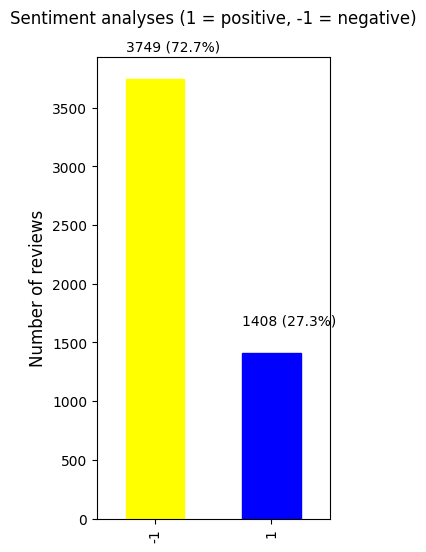

In [4]:
ax = reviews['sentiment'].value_counts().plot(kind='bar', figsize=(3, 6), fontsize=10)
ax.set_title('Sentiment analyses (1 = positive, -1 = negative)', size=12, pad=24)
ax.set_ylabel('Number of reviews', fontsize=12)

N = len(reviews)
colors= ['yellow','blue']
idx = 0
for i in ax.patches:
    ax.text(i.get_x(), i.get_height() + 240, f"{str(round(i.get_height(), 2))} ({round(i.get_height()*100/N, 2)}%)", fontsize=10)
    i.set_color(colors[idx])
    idx+=1

#### data cleaning & preprocessing:

In [4]:
stopwords = ['a', 'about', 'an', 'am' 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', \
             'even', 'ever', 'for', 'from', 'get', 'had', 'has', 'have', 'he', 'her', 'hers', 'his', \
             'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'me', 'my', 'of', 'on', 'or', \
             'see', 'seen', 'she', 'so', 'than', 'that', 'the', 'their', 'there', 'they', 'this', \
             'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'you']

short_forms = {
    "don't": "do not",
    "can't": "cannot",
    "won't": "will not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "didn't": "did not",
    "doesn't": "does not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "couldn't": "could not",
    "should've": "should have",
    "would've": "would have",
    "might've": "might have",
    "must've": "must have",
    # Add more short forms and their full forms as needed
}

def replace_short_forms(text):
    # Create a regular expression pattern to match short forms as standalone words
    pattern = r'\b(?:{})\b'.format('|'.join(short_forms.keys()), re.IGNORECASE)
    
    # Replace short forms with their corresponding full forms using a lambda function
    full_forms_text = re.sub(pattern, lambda match: short_forms[match.group(0)], text)
    
    return full_forms_text


# (?) remove quotation marks, unnecessary punctuation, [{}[]\/+*%|^%#@!?()]
def punctuation_remover(text):
    pattern = r'[{}\[\]\\\/\+\*%\|\^%#@\(\)\$\"]'
    return re.sub(pattern, ' ', text)


def lemma_stopwords_token(text):
      le=WordNetLemmatizer()
      word_tokens=nltk.word_tokenize(text)
      word_tokens =[token for token in word_tokens if token.isalpha()]
      tokens=[le.lemmatize(token) for token in word_tokens if token not in stopwords and len(token)>2]
      processed_text =" ".join(tokens)
      return processed_text


# main preprocessing function
def preprocessing(text):
    reviews = replace_short_forms(text)
    reviews = punctuation_remover(reviews)
    reviews = lemma_stopwords_token(reviews)
    return reviews

#### data split

In [5]:
# download reviews from dataset and preprocess them into a list
data = [preprocessing(custom_comment) for custom_comment in reviews['custom_comment'].to_list()]

# download label into a list
label = [label for label in reviews['sentiment'].to_list()]

In [9]:
# Extract features from the preprocessed data and fit it
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

#### fit & train the model,  run predictions and analyze the results 

In [10]:
clf_Naive_Bayes = MultinomialNB()
clf_Naive_Bayes.fit(X_train, y_train)

# Form a prediction set
prediction = clf_Naive_Bayes.predict(X_test)


# Report the confusion matrix
print(metrics.confusion_matrix(y_test, prediction))

# Print a classification report
print(metrics.classification_report(y_test,prediction))

# Print the overall accuracy
print(metrics.accuracy_score(y_test, prediction))


[[739   4]
 [ 63 226]]
              precision    recall  f1-score   support

          -1       0.92      0.99      0.96       743
           1       0.98      0.78      0.87       289

    accuracy                           0.94      1032
   macro avg       0.95      0.89      0.91      1032
weighted avg       0.94      0.94      0.93      1032

0.935077519379845


In [9]:
# # Save the trained model for later use
joblib.dump(clf_Naive_Bayes, 'model_sentiment_Naive_Bayes.joblib')

['model_sentiment_Naive_Bayes.joblib']

In [10]:
# Fit the Linear SVC model on the training set
from sklearn.svm import LinearSVC

clf_LinearSVC = LinearSVC(max_iter=5000)
clf_LinearSVC.fit(X_train, y_train)
y_pred = clf_LinearSVC.predict(X_test)


# Report the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print a classification report
print(metrics.classification_report(y_test,y_pred))

# Print the overall accuracy
print(metrics.accuracy_score(y_test, y_pred))

[[738   5]
 [ 42 247]]
              precision    recall  f1-score   support

          -1       0.95      0.99      0.97       743
           1       0.98      0.85      0.91       289

    accuracy                           0.95      1032
   macro avg       0.96      0.92      0.94      1032
weighted avg       0.96      0.95      0.95      1032

0.9544573643410853


In [12]:
# Save the trained model for later use
joblib.dump(clf_LinearSVC, 'model_sentiment_LinearSVC.joblib')

['model_sentiment_LinearSVC.joblib']

#### adding SMOTE Technique *(Synthetic Minority Oversampling Technique)*

In [ ]:
# !pip install imbalanced-learn

*What smote does is simple. First it finds the n-nearest neighbors in the minority class for each of the samples in the class . Then it draws a line between the neighbors an generates random points on the lines.*

In [13]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter


counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE
smt = SMOTE()

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({-1: 3006, 1: 1119})
After Counter({-1: 3006, 1: 3006})


In [14]:
# Naïve Bayes - SMOTE Resampling:

clf_Naive_Bayes_SMOTE = MultinomialNB()
clf_Naive_Bayes_SMOTE.fit(X_train_sm, y_train_sm)

# Form a prediction set
prediction = clf_Naive_Bayes_SMOTE.predict(X_test)


# Report the confusion matrix
print(metrics.confusion_matrix(y_test, prediction))

# Print a classification report
print(metrics.classification_report(y_test,prediction))

# Print the overall accuracy
print(metrics.accuracy_score(y_test, prediction))

[[712  31]
 [ 35 254]]
              precision    recall  f1-score   support

          -1       0.95      0.96      0.96       743
           1       0.89      0.88      0.89       289

    accuracy                           0.94      1032
   macro avg       0.92      0.92      0.92      1032
weighted avg       0.94      0.94      0.94      1032

0.936046511627907


In [15]:
# Save the trained model for later use
joblib.dump(clf_Naive_Bayes_SMOTE, 'model_sentiment_Naive_Bayes_SMOTE.joblib')

['model_sentiment_Naive_Bayes_SMOTE.joblib']

In [16]:
# LinearSVC(max_iter=5000) - SMOTE Resampling:

clf_LinearSVC_SMOTE = LinearSVC(max_iter=5000)
clf_LinearSVC_SMOTE.fit(X_train_sm, y_train_sm)

# Form a prediction set
prediction = clf_LinearSVC_SMOTE.predict(X_test)


# Report the confusion matrix
print(metrics.confusion_matrix(y_test, prediction))

# Print a classification report
print(metrics.classification_report(y_test,prediction))

# Print the overall accuracy
print(metrics.accuracy_score(y_test, prediction))

[[723  20]
 [ 30 259]]
              precision    recall  f1-score   support

          -1       0.96      0.97      0.97       743
           1       0.93      0.90      0.91       289

    accuracy                           0.95      1032
   macro avg       0.94      0.93      0.94      1032
weighted avg       0.95      0.95      0.95      1032

0.9515503875968992


In [17]:
# Save the trained model for later use
joblib.dump(clf_LinearSVC_SMOTE, 'model_sentiment_LinearSVC_SMOTE.joblib')

['model_sentiment_LinearSVC_SMOTE.joblib']

#### testing the model

In [18]:
def prepare_new_reviews(text):
  """
  Prepare new text for model testing: preprocess it, vectorize, predict label and return it
  """
  
  preprocessed_text = preprocessing(text)
  features = vectorizer.transform([preprocessed_text])
  loaded_model = joblib.load('model_sentiment_Naive_Bayes_SMOTE.joblib')
  prediction = loaded_model.predict(features)
  # return prediction[0]

  if prediction[0] == 1:
    return "Sentiment: positive"
  else:
    return "Sentiment: negative"


# in this list you can indicate which news to classify
reviews_example = ["the ride was pretty nice",
                """The drivers behaviour is inappropriate""",
                """I had a couple of rides with your service before and they were nice, but this time there wasn't a seatbelt which I believe is totally not OK. and the driver just said Are yoou going or not??""",
                """reckless driver!""",
                """Nice driver, really helpful""",
                """vehicle of premium class""",
                """Great experience.I'd recommend this service to my friends.""",
                "smooth ride",
                "it took longer time, but the driver was good"]

for i,review in enumerate(reviews_example):
  print(f"{i}. {review}")
  print(f"{prepare_new_reviews(review)}")
  

0. the ride was pretty nice
Sentiment: positive
1. The drivers behaviour is inappropriate
Sentiment: negative
2. I had a couple of rides with your service before and they were nice, but this time there wasn't a seatbelt which I believe is totally not OK. and the driver just said Are yoou going or not??
Sentiment: negative
3. reckless driver!
Sentiment: negative
4. Nice driver, really helpful
Sentiment: positive
5. vehicle of premium class
Sentiment: positive
6. Great experience.I'd recommend this service to my friends.
Sentiment: positive
7. smooth ride
Sentiment: positive
8. it took longer time, but the driver was good
Sentiment: negative


#### **DL, RNN**

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential


##### prepare data

In [7]:
data = [preprocessing(custom_comment) for custom_comment in reviews['custom_comment'].to_list()]
labels = reviews['sentiment'].values.tolist()

labels = [0 if label == -1 else label for label in labels]
labels = np.array(labels)

In [8]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [10]:
# Tokenize the text and convert to sequences (raw string input into integer input suitable for a Keras Embedding layer)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)    #assigns a unique integer index to each word in the vocabulary, stored in tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1    #total number of unique words in the vocabulary

# train_seq = tokenizer.texts_to_sequences(X_train)    #convert each text to a sequence of integers based on the word index created during fitting. The result is a list of sequences, where each sequence corresponds to a sentence or document
# test_seq = tokenizer.texts_to_sequences(X_test)

train_seq = tokenizer.texts_to_matrix(X_train)    #convert a list of texts to a Numpy matrix
test_seq = tokenizer.texts_to_matrix(X_test)

# padding to ensure that all sequences have the same length
train_pad = pad_sequences(train_seq, padding='post')
test_pad = pad_sequences(test_seq, padding='post')


##### build RNN Model

In [11]:
embedding_dim = 50   #hyperparameter representing the dimensionality of the embedding space, in NLP tasks often set to a value between 50 and 300

model = Sequential()
model.add(Embedding(input_dim = vocab_size, # The size of our vocabulary 
                    output_dim = embedding_dim, # Dimensions to which each words shall be mapped
                    # input_length = ... Length of input sequences
                    )) 

model.add(SimpleRNN(64, # number of units (neurons), 64, 128, or 256 
                    return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(128, activation="relu")) 
model.add(Dropout(0.4)) 
model.add(Dense(1, activation="sigmoid"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          239200    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          7360      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 263,265
Trainable params: 263,265
Non-trai

In [12]:
# compiling model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]) 

# training the model
history = model.fit(train_pad, y_train, #Training data : features (review) and classes (positive or negative)
                    batch_size=64, #Number of samples to work through before updating the internal model parameters via back propagation. The higher the batch, the more memory you need.
                    epochs=5,
                    # validation_split=0.2, # The model will set apart his fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.
                    verbose=1) 

Epoch 1/5
65/65 [==============================] - 619s 10s/step - loss: 0.5945 - accuracy: 0.7241
Epoch 2/5
65/65 [==============================] - 684s 11s/step - loss: 0.5921 - accuracy: 0.7287
Epoch 3/5
65/65 [==============================] - 703s 11s/step - loss: 0.5942 - accuracy: 0.7285
Epoch 4/5
65/65 [==============================] - 742s 11s/step - loss: 0.6008 - accuracy: 0.7268
Epoch 5/5
65/65 [==============================] - 544s 8s/step - loss: 0.5980 - accuracy: 0.7282


#### Long Short Term Memory (LSTM) 

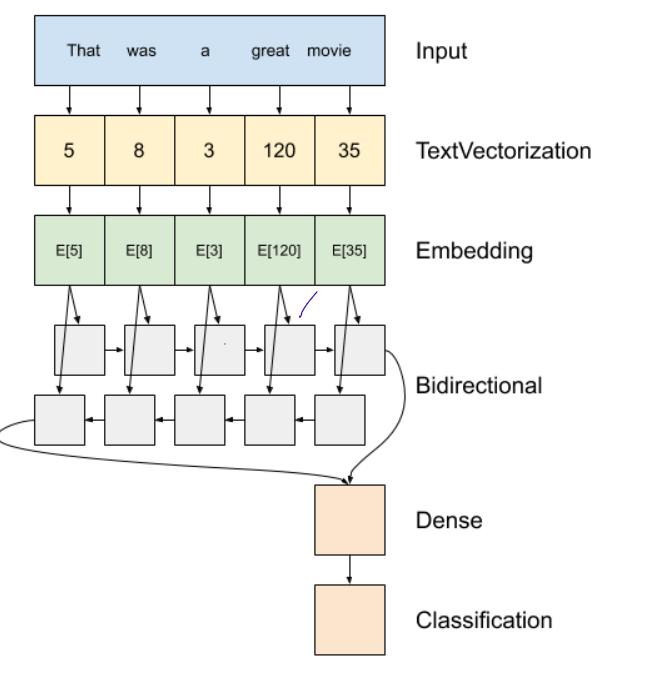

1. This model can be build as a ```tf.keras.Sequential```.

2. The first layer is the ```encoder```, which converts the text to a sequence of token indices.

3. After the encoder is an **embedding layer**. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a ```tf.keras.layers.Dense``` layer.

4. A **recurrent neural network (RNN)** processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

The ```tf.keras.layers.Bidirectional``` wrapper can be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

* The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

* The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two ``layers.Dense`` do some final processing, and convert from this vector representation to a single logit as the classification output.


Here is what the flow of information looks like when we **Stack two or more LSTM layers** with ``return_sequences=True``:

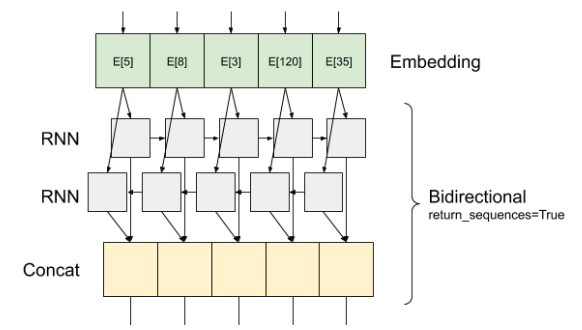

In [50]:
embedding_dim = 50   #hyperparameter representing the dimensionality of the embedding space, in NLP tasks often set to a value between 50 and 300
                    #each word index in the vocabulary will be represented as a 50-dimensional vector in the embedding space
max_length =  400 #Keeping a fixed length of all reviews to max 400 words

lstm_model = Sequential()
# Turns positive integers (indexes) into dense vectors of fixed size.
lstm_model.add(Embedding( 
    input_dim = vocab_size, # int, the size of our vocabulary, maximum integer index + 1 
    output_dim = embedding_dim, # int, dimensions to which each words shall be mapped
    input_length = max_length #Length of input sequences
    ))

#Bidirectional LSTM processes the input sequence in both directions, capturing information from both past and future context
# units - LSTM units in this layer
# return_sequences - True if LSTM layer to return the full sequence of outputs for each input sequence when stacking multiple RNN layers
# activation='tanh' - default
# recurrent_activation='sigmoid' - default
lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Another Bidirectional LSTM layer with 32 units processes the output sequence of the previous layer, summarizing the information learned from the bidirectional LSTM 
lstm_model.add(Bidirectional(LSTM(units=32))) # 32 

# Dense layer = regular fully-connected NN layer, in RNN used with recurrent layer to make predictions based on the learnt representations from the sequences
lstm_model.add(Dense(units=32, activation="relu"))

# applies Dropout to the input, helps prevent overfitting
lstm_model.add(Dropout(rate=0.25)) # Randomly disable 25% of neurons/ # Dropout layers fight overfitting and forces the model to learn multiple representations of the same data by randomly disabling neurons in the learning phase.

# units=num_classes
lstm_model.add(Dense(units=1, activation="sigmoid"))

# compiling model
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #1e-3 = 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.FalseNegatives()]) 

# Display a summary of the models structure
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 50)          239200    
                                                                 
 lstm_2 (LSTM)               (None, 32)                10624     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249,857
Trainable params: 249,857
Non-trainable params: 0
_________________________________________________________________


In [51]:
# training the model
history = lstm_model.fit(train_pad, y_train, #Training data : features (review) and classes (positive or negative)
                    batch_size=64, #Number of samples to work through before updating the internal model parameters via back propagation. The higher the batch, the more memory you need.
                    epochs=5,
                    # validation_split=0.2, # The model will set apart his fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.
                    verbose=1) 

Epoch 1/5
65/65 [==============================] - 7s 79ms/step - loss: 0.6110 - accuracy: 0.7103
Epoch 2/5
65/65 [==============================] - 5s 80ms/step - loss: 0.5855 - accuracy: 0.7287
Epoch 3/5
65/65 [==============================] - 5s 82ms/step - loss: 0.5891 - accuracy: 0.7287
Epoch 4/5
65/65 [==============================] - 5s 82ms/step - loss: 0.5869 - accuracy: 0.7287
Epoch 5/5
65/65 [==============================] - 5s 81ms/step - loss: 0.5878 - accuracy: 0.7287
